In [25]:
import glob
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import StratifiedKFold
from keras.layers import (Input, Dense, TimeDistributed, Activation, LSTM, GRU,
                          Dropout, merge, Reshape, Flatten, RepeatVector,
                          Conv1D, MaxPooling1D, SimpleRNN)
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import keras_util as ku
from autoencoder import encoder
from survey_autoencoder import preprocess, main as survey_autoencoder
from light_curve import LightCurve

import re
import astropy.time
import datetime
import matplotlib.pyplot as plt

from keras.optimizers import Adam

In [23]:
lightcurves = pd.read_parquet("/data/object_lightcurves_small.parquet", )

In [26]:

def visit_to_mjd(visit):
    YEAR_POS = 100000000
    MONTH_POS = 1000000
    DAY_POS = 10000
    year = int(visit/YEAR_POS)
    month = int(visit/MONTH_POS % 100)
    decimal_day = visit/DAY_POS % 100
    hours = (decimal_day % 1) * 24
    minutes = (hours % 1) * 60
    seconds = (minutes % 1) * 60
    d = datetime.datetime(year, month, int(decimal_day), int(hours), int(minutes), int(seconds))
    time = astropy.time.Time(d)
    return time.mjd

    
    
# 2010 12 10 2874
print(visit_to_mjd(201012102874))


55540.28739583334


In [ ]:
lightcurves.where(lightcurves['flux_auto'].map(len) >= 200)

In [196]:
%%time

lightcurve_objects = []

lc_stds = lightcurves['flux_auto'].where(lightcurves['flux_auto'].map(len) >= 200).map(lambda x: np.std(x)/np.mean(x))
for id, lc in lightcurves.where(lc_stds > 0.4).dropna().head(400).iterrows():
    
    if(len(lc['mag_best']) != len(lc['zeropoint'])):
        # This is weird and should not be in the database, but somehow it is
        continue
        
    calib_mag = lc['mag_best'] + lc['zeropoint']
    mjds = np.array([visit_to_mjd(visit) for visit in lc['visit']])

    sel, = np.where((calib_mag < 50) & (calib_mag > 0))
    idx_sort = np.argsort(mjds[sel])
    sorted_sel = sel[idx_sort]

    lightcurve = LightCurve(mjds[sorted_sel], calib_mag[sorted_sel], lc['magerr_best'][sorted_sel])
    lightcurve_objects.append(lightcurve)
    
len(lightcurve_objects)

CPU times: user 1min 45s, sys: 278 ms, total: 1min 45s
Wall time: 1min 45s


In [126]:

def setup_model(input_args, classes, input_shape):

    args = ku.parse_model_args(input_args)

    args.loss = 'categorical_crossentropy'
    model_type_dict = {'gru': GRU, 'lstm': LSTM, 'vanilla': SimpleRNN,
                           'conv': Conv1D}#, 'atrous': AtrousConv1D, 'phased': PhasedLSTM}


    model_input = Input(shape=(input_shape[1], input_shape[-1]), name='main_input')
    encode = encoder(model_input, layer=model_type_dict[args.model_type],
                     output_size=args.embedding, **vars(args))

    scale_param_input = Input(shape=(2,), name='scale_params')
    merged = merge([encode, scale_param_input], mode='concat')

    out = Dense(args.size + 2, activation='relu')(merged)
    out = Dense(len(classes), activation='softmax')(out)
    model = Model([model_input, scale_param_input], out)

    run = ku.get_run_id(**vars(args))
    if args.pretrain:
        for layer in model.layers:
            layer.trainable = False
        pretrain_weights = os.path.join('keras_logs', 
                                        args.pretrain, run, 'weights.h5')
    else:
        pretrain_weights = None

    optimizer = Adam(lr=args.lr)
    model.compile(optimizer=optimizer, loss=args.loss, metrics=['accuracy'],
                      sample_weight_mode='temporal')
    model.load_weights(pretrain_weights, by_name=True)
    
    return model
 

In [127]:
#linear/n200/gru_096_x2_1m03_drop25_emb64_bidir
input_args = {"pretrain": "linear/n200",
        "model_type": "gru",
        "size": 96,
        "num_layers": 2,
        "lr": 0.001,
        "drop_frac": 0.25,
        "embedding": 64,
        "sim_type": "linear",
        "bidirectional": True,
        "m_max": 24.0,
       }
classes = ['RR_Lyrae_FM', 'W_Ursae_Maj', 'Classical_Cepheid',
               'Beta_Persei', 'Semireg_PV']

input_shape = (1, 200, 2)

model = setup_model(input_args, classes, input_shape)

/home/centos/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/centos/miniconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [197]:
out_classifications = np.zeros((len(lightcurve_objects), len(classes)))

for n, lightcurve in enumerate(lightcurve_objects):
    X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in lightcurve.split(args.n_min, args.n_max)]

    if(len(X_list) == 0):
        continue
    X_raw = pad_sequences(X_list, value=np.nan,
                      dtype='float', padding='post')

    X, means, scales, wrong_units = preprocess(X_raw, args.m_max)
    out = model.predict([X, np.c_[means, scales]])
    out_classifications[n,:] = np.nanmean(out, axis=0)

/home/centos/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


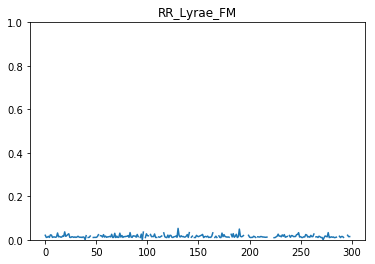

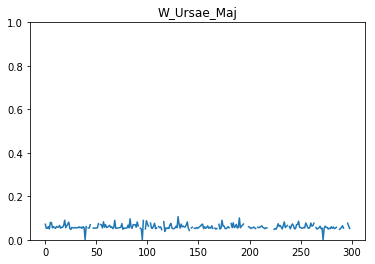

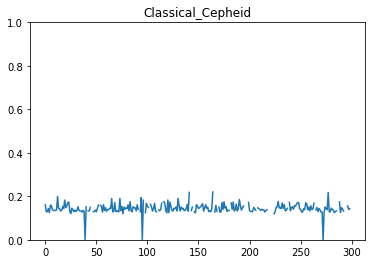

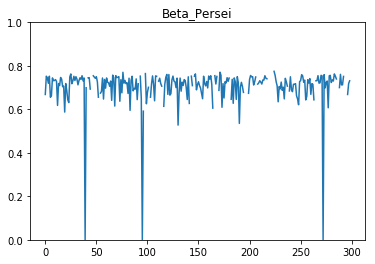

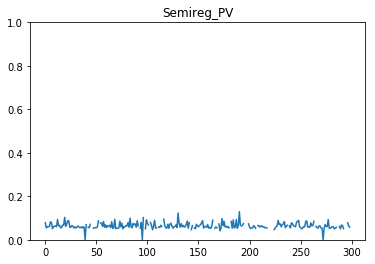

In [198]:
for n in range(0, 5):
    plt.plot(out_classifications[:, n])
    plt.title(classes[n])
    plt.ylim(0, 1)
    plt.show()

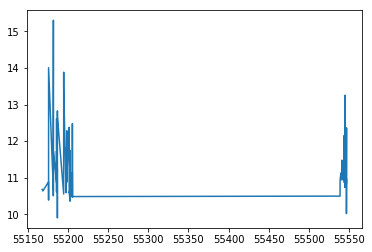

In [199]:
lc_n = np.argmax(np.nan_to_num(out_classifications[:,4]))
lc_of_interest = lightcurve_objects[lc_n]



plt.plot(lc_of_interest.times, lc_of_interest.measurements)